# Predicting Federal Reserve Rate Cuts Using Macroeconomic Indicators
2025-12-19 — Last updated: 2026-02-05

## Objective
This project aims to estimate the probability of a Federal Reserve interest rate cut at the next FOMC meeting using publicly available macroeconomic data.

Rather than producing a deterministic forecast, the goal is to generate a probabilistic and interpretable signal that can support macroeconomic analysis and decision-making.


⚠️ This project is for educational and analytical purposes only and does not constitute financial advice.


## Data Sources

All data are sourced from the Federal Reserve Economic Data (FRED):
- Effective Federal Funds Rate
- CPI and Core CPI
- Unemployment Rate
- Retail Sales
- US Treasury Yields (2Y, 10Y)

The target variable is derived from changes in the Federal Funds Target Rate following FOMC meetings.


In [1]:
pip install pandas numpy matplotlib fredapi yfinance scikit-learn statsmodels


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip -q install fredapi

import pandas as pd
from fredapi import Fred


In [3]:
import os
from fredapi import Fred

fred = Fred(api_key=os.getenv("FRED_API_KEY"))


In [4]:
series = {
    "effr": "DFF",            # Effective Fed Funds Rate
    "cpi": "CPIAUCSL",        # CPI
    "core_cpi": "CPILFESL",   # Core CPI
    "unrate": "UNRATE",       # Unemployment rate
    "retail": "RSAFS",        # Retail sales
    "t10y": "DGS10",          # 10Y Treasury
    "t2y": "DGS2"             # 2Y Treasury
}


## Data Preparation and Feature Engineering

Macroeconomic series are resampled at a monthly frequency and forward-filled to ensure temporal alignment.
Several derived features are constructed to capture economic dynamics rather than levels.


In [5]:
df = pd.DataFrame({k: fred.get_series(v) for k, v in series.items()})
df.index = pd.to_datetime(df.index)
df = df.sort_index()


In [6]:
df.tail()


,effr,cpi,core_cpi,unrate,retail,t10y,t2y
2026-02-01,3.64,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-02,3.64,NaN,NaN,NaN,NaN,4.29,3.57
2026-02-03,3.64,NaN,NaN,NaN,NaN,4.28,3.57
2026-02-04,3.64,NaN,NaN,NaN,NaN,4.29,3.57
2026-02-05,3.64,NaN,NaN,NaN,NaN,4.21,3.47


In [7]:
df_m = df.resample("MS").mean()


In [8]:
df_m = df_m.ffill()


In [9]:
df_m

,effr,cpi,core_cpi,unrate,retail,t10y,t2y
1947-01-01,NaN,21.480,NaN,NaN,NaN,NaN,NaN
1947-02-01,NaN,21.620,NaN,NaN,NaN,NaN,NaN
1947-03-01,NaN,22.000,NaN,NaN,NaN,NaN,NaN
1947-04-01,NaN,22.000,NaN,NaN,NaN,NaN,NaN
1947-05-01,NaN,21.950,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-10-01,4.088065,324.368,330.542,4.4,731412.0,4.061818,3.521364
2025-11-01,3.876333,325.031,331.068,4.5,735904.0,4.093889,3.550000
2025-12-01,3.720645,326.030,331.860,4.4,735904.0,4.143182,3.500909
2026-01-01,3.640000,326.030,331.860,4.4,735904.0,4.213500,3.537000


In [10]:
df_m["inflation_yoy"] = df_m["cpi"].pct_change(12) * 100
df_m["core_inflation_yoy"] = df_m["core_cpi"].pct_change(12) * 100


In [11]:
df_m["effr_change_3m"] = df_m["effr"].diff(3)


In [12]:
df_m["unrate_change_3m"] = df_m["unrate"].diff(3)


In [13]:
df_m["yield_curve_10y_2y"] = df_m["t10y"] - df_m["t2y"]


In [14]:
macro_df = df_m.dropna().copy()
macro_df.tail()


,effr,cpi,core_cpi,unrate,retail,t10y,t2y,inflation_yoy,core_inflation_yoy,effr_change_3m,unrate_change_3m,yield_curve_10y_2y
2025-10-01,4.088065,324.368,330.542,4.4,731412.0,4.061818,3.521364,2.789925,2.752356,-0.241935,0.1,0.540455
2025-11-01,3.876333,325.031,331.068,4.5,735904.0,4.093889,3.550000,2.711969,2.618879,-0.453667,0.2,0.543889
2025-12-01,3.720645,326.030,331.860,4.4,735904.0,4.143182,3.500909,2.653312,2.648966,-0.504022,0.0,0.642273
2026-01-01,3.640000,326.030,331.860,4.4,735904.0,4.213500,3.537000,2.176216,2.192838,-0.448065,0.0,0.676500
2026-02-01,3.640000,326.030,331.860,4.4,735904.0,4.267500,3.545000,1.956063,1.961748,-0.236333,-0.1,0.722500


In [15]:
fed_target = fred.get_series("DFEDTARU")
fed_target = fed_target.to_frame("target_rate")
fed_target.index = pd.to_datetime(fed_target.index)
fed_target = fed_target.sort_index()


In [16]:
fomc = fed_target.resample("MS").last()
fomc["rate_change"] = fomc["target_rate"].diff()


## Target Variable Construction

FOMC decisions are encoded as:
- 1: Rate hike
- 0: Hold
- -1: Rate cut

For modeling purposes, the problem is reframed as a binary classification:
Rate Cut vs No Cut.


In [17]:
def encode_decision(x):
    if x > 0:
        return 1      # Hike
    elif x < 0:
        return -1     # Cut
    else:
        return 0      # Hold

fomc["y"] = fomc["rate_change"].apply(encode_decision)


## Exploratory Data Analysis

The EDA explores how macroeconomic conditions differ across Fed decision regimes.


In [18]:
fomc = fomc[fomc.index >= "2005-01-01"].copy()
fomc.tail()


,target_rate,rate_change,y
2025-10-01,4.00,-0.25,-1
2025-11-01,4.00,0.00,0
2025-12-01,3.75,-0.25,-1
2026-01-01,3.75,0.00,0
2026-02-01,3.75,0.00,0


In [19]:
rows = []

for date, row in fomc.iterrows():
    if date in macro_df.index:
        X_row = macro_df.loc[:date].iloc[-1].copy()
        X_row["meeting_date"] = date
        X_row["y"] = row["y"]
        rows.append(X_row)

model_df = pd.DataFrame(rows)


In [20]:
X = model_df.drop(columns=["y", "meeting_date"])
y = model_df["y"]


In [21]:
X.shape, y.value_counts()


((207, 12),
 y
  0.0    177
  1.0     20
 -1.0     10
 Name: count, dtype: int64)

In [22]:
y.value_counts(normalize=True) * 100


y
 0.0    85.507246
 1.0     9.661836
-1.0     4.830918
Name: proportion, dtype: float64

In [23]:
eda_df = model_df.copy()

eda_df.groupby("y")[[
    "inflation_yoy",
    "core_inflation_yoy",
    "unrate",
    "unrate_change_3m",
    "yield_curve_10y_2y",
    "effr_change_3m"
]].mean().round(2)


,inflation_yoy,core_inflation_yoy,unrate,unrate_change_3m,yield_curve_10y_2y,effr_change_3m
y,,,,,,
-1.0,2.31,2.73,4.07,0.10,0.28,-0.45
0.0,2.16,2.31,6.24,-0.03,1.21,0.00
1.0,4.65,4.11,3.86,-0.10,0.12,0.57


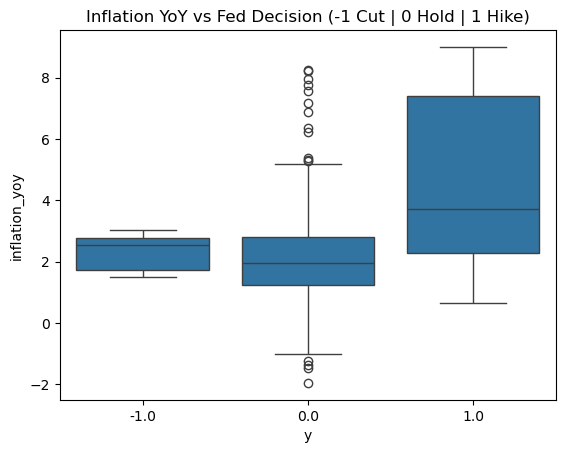

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="y", y="inflation_yoy", data=eda_df)
plt.title("Inflation YoY vs Fed Decision (-1 Cut | 0 Hold | 1 Hike)")
plt.show()


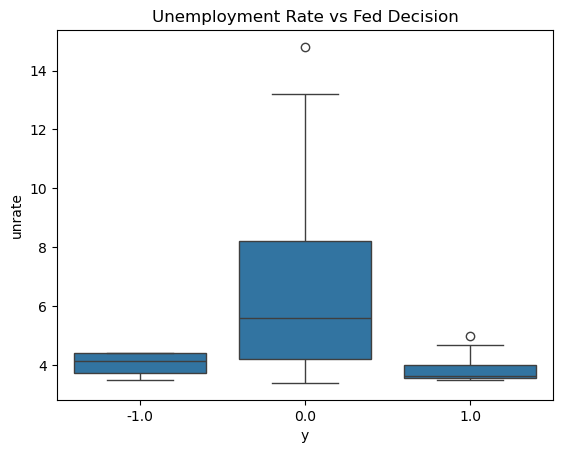

In [25]:
sns.boxplot(x="y", y="unrate", data=eda_df)
plt.title("Unemployment Rate vs Fed Decision")
plt.show()


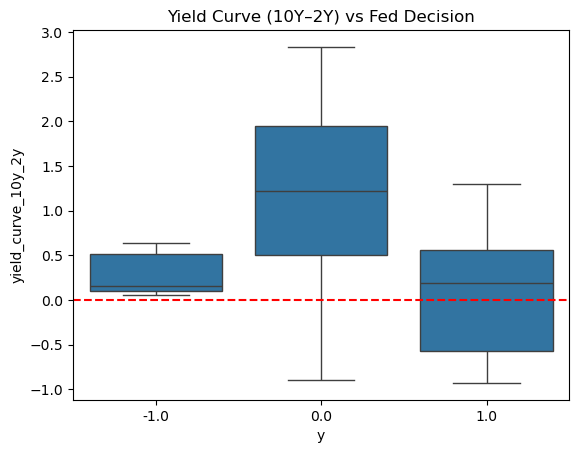

In [26]:
sns.boxplot(x="y", y="yield_curve_10y_2y", data=eda_df)
plt.title("Yield Curve (10Y–2Y) vs Fed Decision")
plt.axhline(0, color="red", linestyle="--")
plt.show()


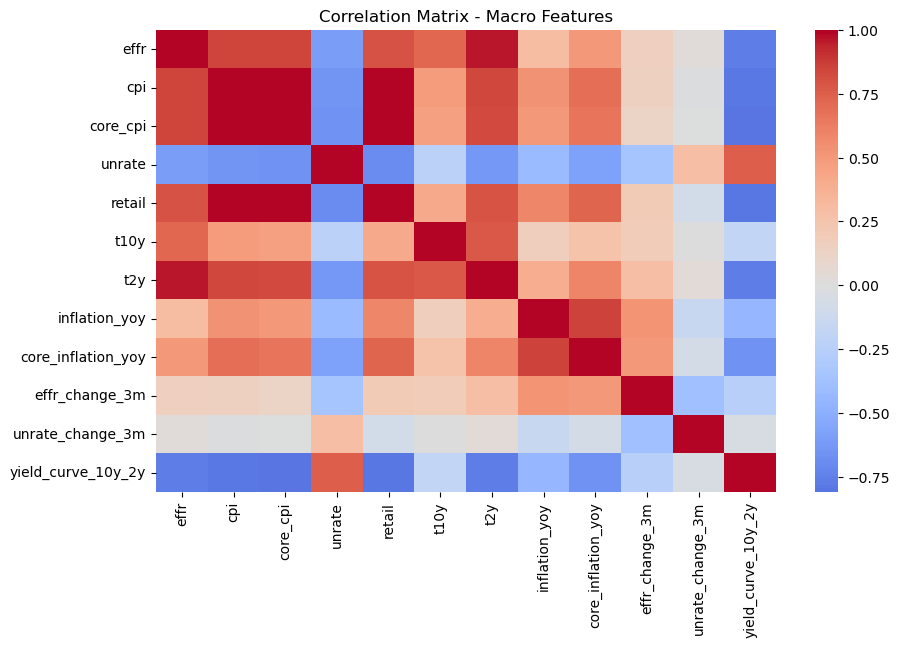

In [27]:
corr = X.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix - Macro Features")
plt.show()


Interpretation of the Correlation Matrix of Macroeconomic Variables

The correlation matrix highlights the linear relationships between the main macroeconomic indicators used to analyze U.S. Federal Reserve monetary policy decisions. Overall, the observed correlations are consistent with economic theory and confirm the relevance of the selected variables for modeling interest rate decisions.

Inflation and Monetary Policy Dynamics

Inflation-related variables — CPI, core CPI, year-over-year inflation, and core inflation YoY — display strong positive correlations with one another, indicating that they capture the same underlying inflationary pressures through different measurement approaches. These inflation indicators are also strongly and positively correlated with the effective federal funds rate (EFFR) and short-term interest rates, particularly the 2-year Treasury yield (t2y).

This relationship reflects the Federal Reserve’s reaction function: when inflationary pressures intensify, the Fed typically tightens monetary policy by raising interest rates to restore price stability.

Labor Market and the Fed’s Dual Mandate

The unemployment rate (unrate) shows a pronounced negative correlation with inflation and interest rate variables. This relationship reflects the Fed’s dual mandate of maintaining price stability and maximizing employment. Rising unemployment is generally associated with economic slowdown, which increases the likelihood of monetary easing.

The variable unrate_change_3m, capturing recent changes in unemployment, also exhibits a negative correlation with effr_change_3m. This suggests that worsening labor market conditions are closely associated with subsequent reductions in policy rates, highlighting unemployment dynamics as a key leading indicator for rate cuts.

Financial Conditions and Market Expectations

Both long-term (10-year Treasury yield, t10y) and short-term (2-year Treasury yield, t2y) interest rates are strongly correlated with the effective federal funds rate. This indicates that financial markets rapidly incorporate current and expected monetary policy decisions into bond yields.

Notably, the strong positive correlation between t2y and inflation-related variables suggests that the 2-year yield is particularly sensitive to expectations of future Fed policy actions, making it a valuable proxy for market-implied policy expectations.

Yield Curve and Recession Signals

The yield_curve_10y_2y variable, representing the slope of the yield curve, stands out with a negative correlation with short-term interest rates and inflation, and a positive correlation with unemployment. An inverted yield curve (negative values) has historically been associated with economic slowdowns and often precedes cycles of monetary easing.

This reinforces the yield curve’s role as a critical leading indicator of regime shifts in monetary policy, particularly transitions from tightening to easing phases.

Economic Activity and Consumption

Retail sales (retail) exhibit a positive correlation with inflation and interest rates, reflecting the link between strong consumer demand, inflationary pressures, and restrictive monetary policy. Conversely, weakening consumption typically coincides with reduced inflation pressures and a more accommodative monetary stance.

Implications for Modeling

The correlation matrix also reveals significant multicollinearity among certain variables, particularly among different inflation measures and interest rate indicators. To mitigate multicollinearity issues during model estimation, it is advisable to select a representative subset of variables — for example, one inflation measure, one labor market indicator, and the yield curve slope.

This approach preserves essential economic information while improving model stability, interpretability, and predictive performance.

In [28]:
y_bin = (y == -1).astype(int)  # 1 = Cut, 0 = No Cut
y_bin.value_counts()


y
0    197
1     10
Name: count, dtype: int64

## Modeling Strategy

A logistic regression model is used due to its interpretability and suitability for small, imbalanced macroeconomic datasets.

A temporal train-test split is applied to avoid look-ahead bias.


In [29]:
features = [
    "inflation_yoy",
    "unrate",
    "unrate_change_3m",
    "yield_curve_10y_2y",
    "effr_change_3m"
]

X_model = X[features]


In [30]:
split_date = "2021-01-01"

X_train = X_model[model_df["meeting_date"] < split_date]
X_test  = X_model[model_df["meeting_date"] >= split_date]

y_train = y_bin[model_df["meeting_date"] < split_date]
y_test  = y_bin[model_df["meeting_date"] >= split_date]

print("Train size:", len(y_train))
print("Test size:", len(y_test))
print("Train classes:\n", y_train.value_counts())
print("Test classes:\n", y_test.value_counts())


Train size: 145
Test size: 62
Train classes:
 y
0    141
1      4
Name: count, dtype: int64
Test classes:
 y
0    56
1     6
Name: count, dtype: int64


In [31]:
y_train.value_counts()


y
0    141
1      4
Name: count, dtype: int64

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight="balanced",
    max_iter=5000,
    solver="lbfgs"
)

model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=5000)

In [34]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.95      0.68      0.79        56
           1       0.18      0.67      0.29         6

    accuracy                           0.68        62
   macro avg       0.57      0.67      0.54        62
weighted avg       0.88      0.68      0.74        62

ROC AUC: 0.8125


In [35]:

X_last = X_model.iloc[[-1]]
X_last


,inflation_yoy,unrate,unrate_change_3m,yield_curve_10y_2y,effr_change_3m
2026-02-01,1.956063,4.4,-0.1,0.7225,-0.236333


In [36]:
X_last_scaled = scaler.transform(X_last)


In [37]:
prob_cut = model.predict_proba(X_last_scaled)[0, 1]

print(f"Estimated probability of a rate cut: {prob_cut:.2%}")



Estimated probability of a rate cut: 32.33%


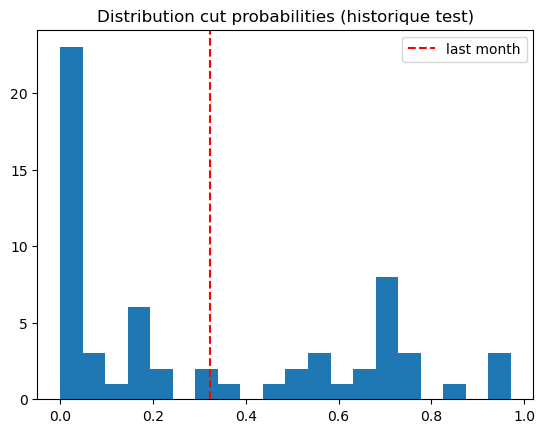

In [38]:
# Distribution historique des probabilités
probs_test = model.predict_proba(X_test_scaled)[:, 1]

import matplotlib.pyplot as plt

plt.hist(probs_test, bins=20)
plt.axvline(prob_cut, color="red", linestyle="--", label="last month")
plt.legend()
plt.title("Distribution cut probabilities (historique test)")
plt.show()


The latest estimated cut probability (≈ 32%) falls in the “Watch” regime. It is above the low-probability mass typically observed in restrictive periods, but it is not in a high-confidence easing regime.

In [39]:
import pandas as pd

coef_df = pd.DataFrame({
    "variable": X_model.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df


,variable,coefficient
0,inflation_yoy,-0.273020
2,unrate_change_3m,-0.477090
4,effr_change_3m,-1.654425
1,unrate,-1.744956
3,yield_curve_10y_2y,-2.259964


The analysis of the logistic regression coefficients shows that the slope of the yield curve (10Y–2Y) is the most influential determinant of the probability of a rate cut, confirming its role as a leading indicator of monetary cycles. The level of unemployment and the recent direction of monetary policy also emerge as major factors. By contrast, inflation—although central to the Fed’s mandate—has a relatively more moderate impact on the probability of a rate cut over the period studied. These results suggest that monetary easing decisions are primarily driven by signals of economic slowdown and a deterioration in financial conditions.

In [40]:

bi_df = model_df.copy()

bi_df["prob_cut"] = model.predict_proba(
    scaler.transform(X_model)
)[:, 1]

bi_df = bi_df.reset_index(drop=True)

bi_df


,effr,cpi,core_cpi,unrate,retail,t10y,t2y,inflation_yoy,core_inflation_yoy,effr_change_3m,unrate_change_3m,yield_curve_10y_2y,meeting_date,y,prob_cut
0,0.155161,211.398,216.925,7.3,324767.0,2.416364,0.820909,-0.022228,1.762460,-1.656505,1.2,1.595455,2008-12-01,0.0,0.951923
1,0.154194,211.933,217.346,7.8,329787.0,2.517500,0.807000,-0.113586,1.672350,-0.815161,1.3,1.710500,2009-01-01,0.0,0.071980
2,0.222143,212.705,217.792,8.3,328376.0,2.870000,0.975263,0.008463,1.800981,-0.165524,1.5,1.894737,2009-02-01,0.0,0.000696
3,0.180645,212.495,218.253,8.7,322634.0,2.819545,0.931364,-0.446479,1.787613,0.025484,1.4,1.888182,2009-03-01,0.0,0.000203
4,0.150333,212.709,218.706,9.0,324323.0,2.927143,0.927143,-0.576324,1.932327,-0.003860,1.2,2.000000,2009-04-01,0.0,0.000155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,4.088065,324.368,330.542,4.4,731412.0,4.061818,3.521364,2.789925,2.752356,-0.241935,0.1,0.540455,2025-10-01,-1.0,0.381715
203,3.876333,325.031,331.068,4.5,735904.0,4.093889,3.550000,2.711969,2.618879,-0.453667,0.2,0.543889,2025-11-01,0.0,0.655232
204,3.720645,326.030,331.860,4.4,735904.0,4.143182,3.500909,2.653312,2.648966,-0.504022,0.0,0.642273,2025-12-01,-1.0,0.692952
205,3.640000,326.030,331.860,4.4,735904.0,4.213500,3.537000,2.176216,2.192838,-0.448065,0.0,0.676500,2026-01-01,0.0,0.627139


In [41]:
bi_df_export = bi_df[[
    "meeting_date",
    "prob_cut",
    "inflation_yoy",
    "unrate",
    "unrate_change_3m",
    "yield_curve_10y_2y",
    "effr_change_3m"
]]


In [42]:
bi_df_export.to_csv("fed_macro_bi.csv", index=False)


In [50]:
bi_df_export = bi_df_export.copy()
bi_df_export.loc[:, "is_last_month"] = 0
bi_df_export.loc[bi_df_export.index[-1], "is_last_month"] = 1


In [51]:
bi_df_export.to_csv("fed_macro_b.csv", index=False)


## Model Evaluation

Model performance is evaluated using ROC-AUC and Precision-Recall metrics, which are more informative than accuracy in imbalanced settings.


In [45]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# 1) S'assurer que c'est trié dans le temps
tmp = model_df[["meeting_date"]].copy()
tmp["meeting_date"] = pd.to_datetime(tmp["meeting_date"])

order = np.argsort(tmp["meeting_date"].values)

X_ts = X_model.iloc[order].copy()
y_ts = y_bin.iloc[order].copy()
dates_ts = tmp.iloc[order]["meeting_date"].reset_index(drop=True)

# 2) Pipeline (scaler + logreg)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=5000, solver="lbfgs"))
])

# 3) Walk-forward CV
tscv = TimeSeriesSplit(n_splits=5) 

rows = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_ts), start=1):
    X_train, X_test = X_ts.iloc[train_idx], X_ts.iloc[test_idx]
    y_train, y_test = y_ts.iloc[train_idx], y_ts.iloc[test_idx]

   
    if y_train.nunique() < 2:
        print(f"Fold {fold}: train contient 1 seule classe -> skip")
        continue

    pipe.fit(X_train, y_train)
    prob = pipe.predict_proba(X_test)[:, 1]
    pred = (prob >= 0.5).astype(int)

    roc = roc_auc_score(y_test, prob) if y_test.nunique() > 1 else np.nan
    pr  = average_precision_score(y_test, prob) if y_test.nunique() > 1 else np.nan

    rows.append({
        "fold": fold,
        "train_end": dates_ts.iloc[train_idx[-1]],
        "test_start": dates_ts.iloc[test_idx[0]],
        "test_end": dates_ts.iloc[test_idx[-1]],
        "test_size": len(test_idx),
        "test_positives": int(y_test.sum()),
        "ROC_AUC": roc,
        "PR_AUC": pr
    })

cv_results = pd.DataFrame(rows)
cv_results


Fold 1: train contient 1 seule classe -> skip
Fold 2: train contient 1 seule classe -> skip
Fold 3: train contient 1 seule classe -> skip


,fold,train_end,test_start,test_end,test_size,test_positives,ROC_AUC,PR_AUC
0,4,2020-06-01,2020-07-01,2023-04-01,34,0,NaN,NaN
1,5,2023-04-01,2023-05-01,2026-02-01,34,6,0.672619,0.523372


The walk-forward evaluation yields ROC-AUC ≈ 0.67 on the only fold containing positive events. This suggests moderate out-of-sample ranking power, but the estimate is noisy because rate cuts are rare and several folds contain no positive cases.

## Walk-Forward Backtesting

A walk-forward validation is implemented to assess model stability across time.
Due to the rarity of rate cuts, only folds containing positive events are evaluable.


In [46]:
print("ROC_AUC mean:", cv_results["ROC_AUC"].mean())
print("PR_AUC mean:", cv_results["PR_AUC"].mean())
cv_results[["fold","train_end","test_start","test_end","test_size","test_positives","ROC_AUC","PR_AUC"]]


ROC_AUC mean: 0.6726190476190476
PR_AUC mean: 0.5233716475095785


,fold,train_end,test_start,test_end,test_size,test_positives,ROC_AUC,PR_AUC
0,4,2020-06-01,2020-07-01,2023-04-01,34,0,NaN,NaN
1,5,2023-04-01,2023-05-01,2026-02-01,34,6,0.672619,0.523372


## Baseline Comparisons

Two baselines are used:
1. Always predict no cut
2. Yield curve inversion rule


In [47]:
# Baseline 1 : toujours 0 (no cut)
y_pred_baseline_hold = np.zeros_like(y_test)

from sklearn.metrics import roc_auc_score, average_precision_score

# ROC-AUC impossible 
print("Baseline HOLD - Accuracy:", (y_pred_baseline_hold == y_test).mean())


Baseline HOLD - Accuracy: 0.8235294117647058


This baseline highlights that accuracy is misleading in an imbalanced classification problem. Although the accuracy appears high, the model fails to detect any rate cuts

In [48]:
# Baseline 2 : 
# cut si yield_curve < 0
y_pred_baseline_yc = (X_test["yield_curve_10y_2y"] < 0).astype(int)

# Probabilit binary (0 ou 1)
y_prob_baseline_yc = y_pred_baseline_yc.copy()

roc_yc = roc_auc_score(y_test, y_prob_baseline_yc) if y_test.nunique() > 1 else np.nan
pr_yc  = average_precision_score(y_test, y_prob_baseline_yc) if y_test.nunique() > 1 else np.nan

print("Yield Curve baseline ROC:", roc_yc)
print("Yield Curve baseline PR :", pr_yc)


Yield Curve baseline ROC: 0.2142857142857143
Yield Curve baseline PR : 0.17647058823529413


The yield curve is a good indicator of the economic cycle, but it is insufficient on its own to accurately anticipate the precise timing of the Fed’s decisions.

In [54]:
def fed_regime(p):
    if p < 0.3:
        return "Restrictive"
        
    elif p < 0.6:
        return "Watch"
    else:
        return "Accommodative"

bi_df_export = bi_df_export.copy()
bi_df_export.loc[:, "fed_regime"] = bi_df_export["prob_cut"].apply(fed_regime)



### Model Performance (Test Set)

The logistic regression reaches a ROC-AUC of 0.81 on the post-2021 test set, indicating good ranking performance: cut episodes are generally assigned higher probabilities than non-cut episodes. Using a 0.5 threshold (reported for simplicity), the model captures a majority of cut events (recall ≈ 0.67) but with low precision (≈ 0.18), reflecting the strong class imbalance and the model’s role as an early-warning signal rather than a strict classifier. In practice, the probability threshold should be chosen based on the objective (higher recall for early warning vs. higher precision to reduce false alarms).

### Walk-Forward Validation

In walk-forward validation, several folds contain no rate-cut events, so ROC/PR metrics are not defined for those splits. On the only evaluable fold, the model reaches ROC-AUC ≈ 0.67 and PR-AUC ≈ 0.52. These estimates suggest moderate out-of-sample skill, but they remain noisy due to the rarity of rate cuts.

### Latest Signal

The most recent estimated probability of a rate cut is about 32%, which falls into the “Watch” regime. This indicates a moderate easing risk relative to restrictive periods, but not a high-confidence easing signal.

### Baselines

A “always no cut” baseline achieves high accuracy due to class imbalance, but provides no detection capability. A simple yield-curve inversion rule (10Y–2Y < 0) performs poorly because inversions can persist long before cuts occur. This highlights that the yield curve contains cycle information but is not sufficient on its own for decision timing.

### Interpretability

In this specification, the yield-curve slope (10Y–2Y) has the largest absolute coefficient. The negative sign implies that a flatter or inverted curve increases the probability of a cut. Unemployment level and recent policy momentum (EFFR change) also contribute meaningfully, consistent with easing decisions being associated with weakening conditions and shifts toward accommodation.

### Limitations (important)

This project uses monthly resampling and derives the target from monthly changes in the target rate, which is a practical proxy and may not match exact meeting dates. Results can change over time as FRED series are updated and revised.